In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
#import spotpy
from matplotlib.offsetbox import AnchoredText
#from scipy import stats, signal, optimize
#import hydroeval as he
sns.set(style='whitegrid', palette='deep')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sdm import SDM

#import statsmodels.api as sm
#import altair as alt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [52]:
#load climate data
#climate = xr.load_dataset('input/RCM_krummh_new.nc')
#climate = xr.load_dataset('C:/Users/Jonas Lenz/Desktop/RUINS/data/hydropaper/input/cordex_coast22x.nc')
climate = xr.load_dataset('C:/Users/Jonas Lenz/Desktop/RUINS/data/hydropaper/input/climate_nobias/cordex_coast_nobias_f32.nc')

In [5]:
# load weather data for bias correction
weather = xr.load_dataset('C:/Users/Jonas Lenz/Desktop/RUINS/data/hydropaper/input/emden.nc')

stat = '__xarray_dataarray_variable__'
w1 = weather[stat].to_dataframe().reset_index(level=[1]).pivot(columns='vars',values=stat)
w1

vars,EToHG,EToPM,EToPM2,EToPT,EToSJ,Prec,RH,Rs,T,Tmax,Tmin,aP,u2,u2mx,vap
time,,,,,,,,,,,,,,,
1998-01-01,0.305726,0.485855,0.367827,0.071718,0.000000,1.6,93.00,1.62,5.3,7.4,2.8,1007.40,5.1,11.0,8.2
1998-01-02,0.303099,0.524855,0.531591,0.142077,0.000000,2.3,93.00,1.44,7.2,8.6,4.8,987.90,7.1,15.6,9.4
1998-01-03,0.319954,0.705129,1.211948,0.461141,0.000000,13.3,89.00,0.41,6.8,9.6,5.3,987.50,9.0,24.4,8.7
1998-01-04,0.244922,1.011402,0.953361,-0.090206,0.000000,7.1,85.00,2.21,6.2,7.4,4.8,991.70,8.4,21.9,8.0
1998-01-05,0.280416,1.184567,1.164553,-0.274831,0.000000,3.3,81.00,2.82,6.0,7.2,3.8,990.90,9.4,23.7,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.255251,0.411452,0.551221,0.165174,0.000000,0.8,87.79,1.13,-0.1,2.9,-2.9,1001.01,4.8,8.2,5.4
2021-12-28,0.276759,0.208440,0.193862,0.144673,0.095483,4.0,97.83,1.32,5.2,6.9,2.9,992.53,4.2,8.6,8.7
2021-12-29,0.330036,0.121127,0.292580,0.327125,0.361670,1.6,98.71,0.77,6.6,9.6,4.6,1002.79,2.8,9.4,9.7


In [6]:
## create key list for anett
#pd.DataFrame(list(climate.keys())).to_csv("key_list.csv", index = False, header=False)

In [7]:
#keys = list(climate.keys())
keys = [s for s in list(climate.keys()) if 'HadGEM2-ES' not in s] #remove all entries of HadGEM2-ES (6 entries) - as done in RUINSapp.py
len(keys)

261

# BIAS correction

In [8]:
def applySDM(wdata, data, meth='rel', cdf_threshold=0.9999999, lower_limit=0.1):
    '''apply structured distribution mapping to climate data and return unbiased version of dataset'''
    from sdm import SDM
    data_ub = data.copy()

    for k in data_ub.columns:
        data_col = data_ub[k].dropna()
        overlapx = pd.concat(
            [wdata.loc[data_col.index[0]:wdata.index[-1]], data_col.loc[data_col.index[0]:wdata.index[-1]]], axis=1)
        overlapx.columns = ['obs', 'cm']
        overlapx = overlapx.dropna()
        try:
            data_ub[k] = SDM(overlapx.obs, overlapx.cm, data_col, meth, cdf_threshold, lower_limit)
        except:
            data_ub[k] = data_ub[k] * np.nan

    data_ub[data_ub == 0.0000000] = np.nan
    data_ub = data_ub.loc[data_ub.index[0]:pd.to_datetime('2099-12-31 23:59:59')]

    return data_ub


In [47]:
stat1 = 'Emden'
z = keys[26]

vari = 'Prec'
meth = 'rel'

#vari = 'T'
#meth = 'abs'

#vari = 'Rs'
#meth = 'abs'

#vari = 'EToHG'
#vari = 'EToPM'
#vari = 'EToSJ'
#vari = 'EToPT'
#meth = 'rel'

#vari = 'u2'
#meth = 'rel'

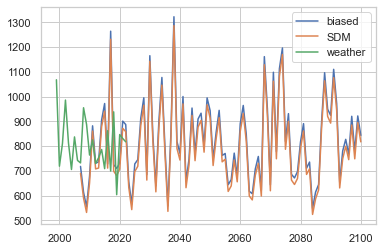

In [48]:
c1 = climate[z].sel(vars=vari).to_dataframe()
c1 = c1[c1.columns[c1.columns != 'vars']]

c2 = applySDM(w1[vari], c1.fillna(0), meth=meth)

if vari in ['Prec', 'EToPM', 'EToHG', 'EToSJ']:
    plot(c1.resample('1y').sum(), label=('biased'))
    plot(c2.resample('1y').sum(), label ='SDM')
    plot(w1[vari].resample('1y').sum(), label ='weather')
else:
    plot(c1.resample('1y').mean(), label=('biased'))
    plot(c2.resample('1y').mean(), label ='SDM')
    plot(w1[vari].resample('1y').mean(), label ='weather')
legend()

In [50]:
sum(c1<=0.01)

GERICS.MIROC5.REMO2015.r1i1p1.rcp26    0
dtype: int64

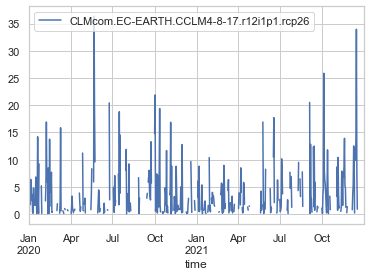

In [26]:
c2['2020':'2021'].plot()

# Checks on single prediction

In [37]:
overview = pd.DataFrame(index = keys)
overview['checkPrec'] = False
overview['EToPM_ok'] = False
overview['EToPM2_ok'] = False
overview['EToHG_ok'] = False
#overview['aP_ok'] = False
#overview['vap_ok'] = False
overview['bias_ok'] = True



overview.head()


,checkPrec,EToPM_ok,EToPM2_ok,EToHG_ok,bias_ok
CLMcom-ETH.M-MPI-ESM-LR.COSMO-crCLIM-v1-1.r1i1p1.rcp85,False,False,False,False,True
CLMcom-ETH.M-MPI-ESM-LR.COSMO-crCLIM-v1-1.r2i1p1.rcp85,False,False,False,False,True
CLMcom-ETH.M-MPI-ESM-LR.COSMO-crCLIM-v1-1.r3i1p1.rcp85,False,False,False,False,True
CLMcom-ETH.NorESM1-M.COSMO-crCLIM-v1-1.r1i1p1.rcp85,False,False,False,False,True
CLMcom.CERFACS-CNRM-CM5.CCLM4-8-17.r1i1p1.rcp45,False,False,False,False,True


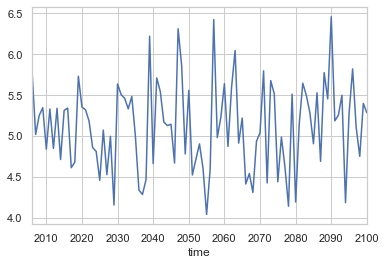

In [38]:
key = keys[10]
overview.loc[key, 'checkPrec']

abc = climate[key].to_dataframe().reset_index(level=[1]).pivot(columns='vars',values=key)
abc.EToHG.resample('1y').max().plot()

In [48]:
# weather dataframe for sdm bias correction
i = 0

for key in keys[50:60]:
    #key = 'DWD.CanESM2.EPISODES2018.r1i1p1.historical'
    print(i)
    i+=1
    
    if True:
        abc = climate[key].to_dataframe().reset_index(level=[1]).pivot(columns='vars',values=key)
        
        vari = 'Rs'
        meth = 'rel'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)

        vari = 'T'
        meth = 'abs'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth)

        vari = 'Tmin'
        meth = 'abs'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth)

        vari = 'Tmax'
        meth = 'abs'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth)

        vari = 'Prec'
        meth = 'rel'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0.1)

        vari = 'RH'
        meth = 'rel'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)

        vari = 'u2'
        meth = 'rel'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)

    #    overview.loc[key, 'vap_ok'] = True
    #    try:
        vari = 'vap'
        meth = 'rel'
        c1 = abc[abc.columns[abc.columns == 'vabar']]  ## vabar in climate -> vap in weather
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)
    #    except:
    #        overview.loc[key, 'vap_ok'] = False

    #    overview.loc[key, 'aP_ok'] = True
    #    try:
        vari = 'aP'
        meth = 'rel'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)
        #except:
         #   overview.loc[key, 'aP_ok'] = False

        vari = 'EToHG'
        meth = 'rel'
        c1 = abc[abc.columns[abc.columns == vari]]
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)

      #  overview.loc[key, 'EToPM2_ok'] = True
      #  try:
        vari = 'EToPM2'
        c1 = abc[abc.columns[abc.columns == 'EToPM']]  ## EToPM in climate -> EToPM2 in weather
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)
        #except:
         #   overview.loc[key, 'EToPM2_ok'] = False

        #overview.loc[key, 'EToPM_ok'] = True
        #try:
        vari = 'EToPM'
        c1 = abc[abc.columns[abc.columns == 'EToPM1']]  ## EToPM1 in climate -> EToPM in weather
        if (isnan(c1[:'2020'].mean()[0])):
            overview.loc[key, 'bias_ok'] = False
        else:
            abc[vari] = applySDM(w1[vari], c1, meth=meth, lower_limit=0)
        #except:
        #    overview.loc[key, 'EToPM_ok'] = False
    
        abc = abc.drop(columns = ["EToPM1", "EToPT", "EToSJ", "vabar"])



    ##########################
        #Tests

        #ET < 4 in less than ten years
        overview.loc[key, 'EToHG_ok'] = sum((abc.EToHG.resample('1y').max() < 4)) < 10
        overview.loc[key, 'EToPM_ok'] = sum((abc.EToPM.resample('1y').max() < 4)) < 10
        ### try except, as EToPM2 is not neccesarely present
        try:
            overview.loc[key, 'EToPM2_ok'] = sum((abc.EToPM2.resample('1y').max() < 4)) < 10
        except:
            pass
        # No Prec years in 2010-2020 and 2090-2100
        overview.loc[key, 'checkPrec'] = not (any(abc.Prec.resample('1y').sum()['2010':'2020'] <=0) or any(abc.Prec.resample('1y').sum()['2090':'2099'] <=0))


    #overview['Rs_ok'] = False
    #overview['T_ok'] = False
    #overview['Tmin_ok'] = False
    #overview['Tmax_ok'] = False
    #overview['Prec_ok'] = False
    #overview['RH_ok'] = False
    #overview['u2_ok'] = False
    #overview['vap_ok'] = False
    #overview['aP_ok'] = False
#    except:
#        print('failed on '+key)

0
1
2
3
4
5
6
7
8
9


# key auseinander nehmen

In [54]:
def skey(string):
    try:
        return pd.Series(string.split('.'),index=['institute','GCM','RCM','ensemble','RCP'])
    except:
        return pd.Series(string.split('.'),index=['GCM','ensemble','RCM','RCP'])

skey(overview.index[50])

institute         MPI-CSC
GCM          M-MPI-ESM-LR
RCM              REMO2009
ensemble           r2i1p1
RCP                 rcp26
dtype: object

In [75]:
overview['GCM'] = ''
overview['RCM'] = ''
overview['ensemble'] = ''
overview['RCP'] = ''
overview['institute'] = ''

for z in overview.index:
    a = skey(z)
    overview.loc[z,'GCM'] = a['GCM']
    overview.loc[z,'RCM'] = a['RCM']
    overview.loc[z,'ensemble'] = a['ensemble']
    overview.loc[z,'RCP'] = a['RCP']
    try:
        overview.loc[z,'institute'] = a['institute']
    except:
        overview.loc[z,'institute'] = ''

In [76]:
overview.iloc[50:60,]

,checkPrec,EToPM_ok,EToPM2_ok,EToHG_ok,bias_ok,GCM,RCM,ensemble,RCP,institute
MPI-CSC.M-MPI-ESM-LR.REMO2009.r2i1p1.rcp26,True,True,True,True,False,M-MPI-ESM-LR,REMO2009,r2i1p1,rcp26,MPI-CSC
MPI-CSC.M-MPI-ESM-LR.REMO2009.r1i1p1.rcp45,True,True,True,True,True,M-MPI-ESM-LR,REMO2009,r1i1p1,rcp45,MPI-CSC
MPI-CSC.M-MPI-ESM-LR.REMO2009.r2i1p1.rcp45,True,True,True,True,True,M-MPI-ESM-LR,REMO2009,r2i1p1,rcp45,MPI-CSC
MPI-CSC.M-MPI-ESM-LR.REMO2009.r1i1p1.rcp85,True,True,True,True,True,M-MPI-ESM-LR,REMO2009,r1i1p1,rcp85,MPI-CSC
MPI-CSC.M-MPI-ESM-LR.REMO2009.r2i1p1.rcp85,True,True,True,True,True,M-MPI-ESM-LR,REMO2009,r2i1p1,rcp85,MPI-CSC
UHOH.M-MPI-ESM-LR.WRF361H.r1i1p1.rcp85,True,True,True,True,True,M-MPI-ESM-LR,WRF361H,r1i1p1,rcp85,UHOH
CanESM2.v1-r1.WETTREG2013.rcp85,True,True,True,True,False,CanESM2,WETTREG2013,v1-r1,rcp85,
CanESM2.v1-r10.WETTREG2013.rcp85,True,True,True,True,False,CanESM2,WETTREG2013,v1-r10,rcp85,
CanESM2.v1-r2.WETTREG2013.rcp85,True,True,True,True,False,CanESM2,WETTREG2013,v1-r2,rcp85,
CanESM2.v1-r3.WETTREG2013.rcp85,True,True,True,True,False,CanESM2,WETTREG2013,v1-r3,rcp85,


# Ein Institut == 1 GCM?

In [85]:
unique(overview['institute'][overview['GCM'] == 'CERFACS-CNRM-CM5'])

array(['', 'CLMcom', 'DMI', 'DWD', 'GERICS', 'KNMI'], dtype=object)

In [83]:
tab = overview.groupby(['institute', 'GCM']).size()
tab

institute   GCM             
            CERFACS-CNRM-CM5    31
            CanESM2             32
            EC-EARTH            30
            M-MPI-ESM-LR        33
            MIROC5              32
CLMcom      CERFACS-CNRM-CM5     2
            EC-EARTH             3
            M-MPI-ESM-LR         2
            MIROC5               1
CLMcom-ETH  M-MPI-ESM-LR         3
            NorESM1-M            1
DMI         CERFACS-CNRM-CM5     1
            EC-EARTH             5
            M-MPI-ESM-LR         1
            NorESM1-M            2
DWD         CERFACS-CNRM-CM5     4
            CanESM2             19
            EC-EARTH             8
            M-MPI-ESM-LR        12
            NorESM1-M            4
GERICS      CERFACS-CNRM-CM5     1
            EC-EARTH             2
            GFDL-GFDL-ESM2G      1
            IPSL-CM5A-LR         1
            IPSL-CM5A-MR         1
            M-MPI-ESM-LR         1
            MIROC5               1
            NorESM1-M     

In [86]:
overview.to_csv('key_list.csv', index = False)